In [23]:
import torch, os
import IPython.display
import numpy as np
import matplotlib.pyplot as plt
from src.models.model import VAE
from src.utils import *
from src.interact_func import *

In [24]:
sample = torch.from_numpy(np.load('data/source_data.npy')).float()
target = torch.from_numpy(np.load('data/target_data.npy')).float()

In [25]:
sample = sample[0].reshape(1, 32, 130).cuda()
target = target[0].reshape(1, 32, 130).cuda()

In [26]:
pitch_dim = np.setdiff1d(range(128), [117, 45, 79, 1, 73]).tolist()
rhythm_dim = np.setdiff1d(range(128), [127, 96, 7, 84, 60]).tolist()

In [27]:
def np_midi(sample_roll, display=False, interpolation=False):
    music = pretty_midi.PrettyMIDI()
    piano_program = pretty_midi.instrument_name_to_program(
        'Acoustic Grand Piano')
    piano = pretty_midi.Instrument(program=piano_program)
    t = 0
    for i in sample_roll:
        if 'torch' in str(type(i)):
            pitch = int(i.max(0)[1])
        else:
            pitch = int(np.argmax(i))
        if pitch < 128:
            note = pretty_midi.Note(
                velocity=100, pitch=pitch, start=t, end=t + 1 / 16)
            t += 1 / 16
            piano.notes.append(note)
        elif pitch == 128:
            if len(piano.notes) > 0:
                note = piano.notes.pop()
            else:
                p = np.random.randint(60, 72)
                note = pretty_midi.Note(
                    velocity=100,
                    pitch=int(p),
                    start=0,
                    end=t
                )
            note = pretty_midi.Note(
                velocity=100,
                pitch=note.pitch,
                start=note.start,
                end=note.end + 1 / 16)
            piano.notes.append(note)
            t += 1 / 16
        elif pitch == 129:
            t += 1 / 16
    music.instruments.append(piano)
        
    return music.get_piano_roll(100)[48:84]

In [28]:
model = load_old_model('params/tr_128.pt')
z = model.encode(sample).mean
zt = model.encode(target).mean
p0=z
p1=zt
interpolation_rate = 1.

t = [0., 0.25, 0.5, 0.75, 1.]

piano_rolls = []
for i in range(5):
    temp = []
    for j in range(5):
        omega = torch.tensor(np.pi/2)
        # pitch
        A = torch.sin((1. - t[i]) * omega) / torch.sin(omega)
        B = torch.sin(t[i] * omega) / torch.sin(omega)
        # rhythm
        A_ = torch.sin((1. - t[j]) * omega) / torch.sin(omega)
        B_ = torch.sin(t[j] * omega) / torch.sin(omega)
        
        z0 = p0 + 0
        z0[:, pitch_dim] *= A
        z0[:, rhythm_dim] *= A_
        z1 = p1 + 0
        z1[:, pitch_dim] *= B
        z1[:, rhythm_dim] *= B_
        z0[:, pitch_dim] += z1[:, pitch_dim]
        z0[:, rhythm_dim] += z1[:, rhythm_dim]
        output = model.decode(z0)
        output = output.cpu().data.numpy()
        output = np_midi(np.concatenate(output, 0))
        temp.append(output)
    piano_rolls.append(temp)
    print("row {} done!".format(i+1))

row 1 done!
row 2 done!
row 3 done!
row 4 done!
row 5 done!


<Figure size 4320x4320 with 0 Axes>

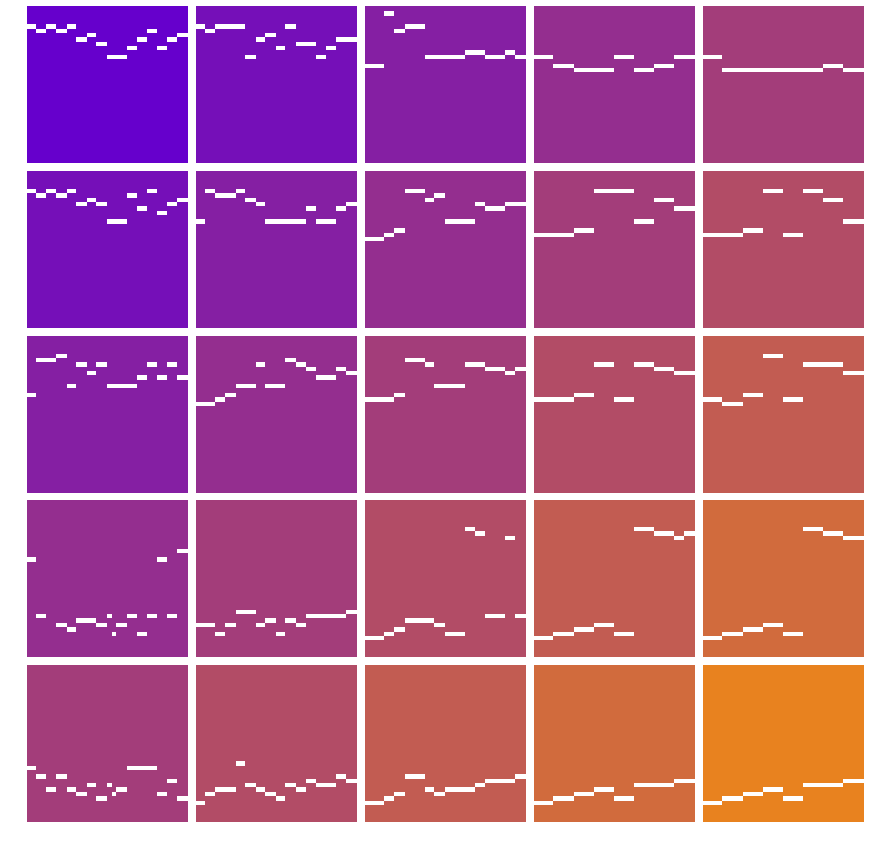

In [29]:
colors = ["#6600cc","#750fb8","#851fa3","#942e8f","#a33d7a","#b24c66","#c25c52","#d16b3d","#e8821f","#f02e14"]
alignment = {'horizontalalignment': 'center', 'verticalalignment': 'baseline'}

plt.figure(figsize=(60, 60))
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

# from top to bottom
for i in range(5):
    
    # from left to right
    for j in range(5):
        ax = axs[i][j]
        cmap = matplotlib.colors.ListedColormap([colors[i+j], "white"])
        ax.pcolor(piano_rolls[i][j], cmap=cmap)
        ax.set_axis_off()
            
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.savefig('interpolation.png',bbox_inches="tight", dpi=300)
plt.show()

In [30]:
os.remove('data/source_data.npy')
os.remove('data/target_data.npy')